In [5]:
import os
from ete3 import Tree
import matplotlib.pyplot as plt
import numpy as np

#max_rf = 34

name_dict = {"full" : "T_f", "glottolog" :  "T_g"}

def rf_distance(t1, t2):
    rf, max_rf, common_leaves, parts_t1, parts_t2,discard_t1, discart_t2 = t1.robinson_foulds(t2, unrooted_trees = True)
    return rf

def quartet_distance(tree_name1, tree_name2):
    os.system("./qdist " + tree_name1 + " " + tree_name2 + " >out.txt")
    qdist = float(open("out.txt").readlines()[1].split("\t")[-1])
    os.remove("out.txt")
    return qdist

def calculate_dm():
    distance_matrix = [[0.0 for _ in range(1000)] for __ in range(1000)]
    trees = [None for _ in range(1000)]
    d = "output/"
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            trees[idx] = Tree(os.path.join(d, entry.name))
    
    for i in range(1000):
        for j in range(i, 1000):
            rfd = rf_distance(trees[i], trees[j])
            distance_matrix[i][j] = rfd
            distance_matrix[j][i] = rfd
            
    with open("temp/distance.matrix", "w+") as dm_file:
        for row in distance_matrix:
            dm_file.write(",".join([str(el) for el in row]) + "\n")
            
    return distance_matrix


def calculate_quartet_dm():
    distance_matrix = [[0.0 for _ in range(1000)] for __ in range(1000)]
    tree_names = ["" for _ in range(1000)]
    d = "output/"
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            tree_names[idx] = os.path.join(d, entry.name)
    
    for i in range(1000):
        print(i)
        for j in range(i, 1000):
            qd = quartet_distance(tree_names[i], tree_names[j])
            distance_matrix[i][j] = qd
            distance_matrix[j][i] = qd
            
    with open("temp/quartet_distance.matrix", "w+") as dm_file:
        for row in distance_matrix:
            dm_file.write(",".join([str(el) for el in row]) + "\n")
            
    return distance_matrix

def calculate_dist_to_fixed(name):
    d_file = open("temp/" + name + "_dist.matrix", "w+")
    trees = [None for _ in range(1000)]
    d = "output/"
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            trees[idx] = Tree(os.path.join(d, entry.name))
    full_tree = Tree(os.path.join("ref_trees", name + ".tree"))
    for t in trees:
        d_file.write(str(rf_distance(t, full_tree)) + "\n")
            
            
def calculate_quartet_dist_to_fixed(name):
    d_file = open("temp/" + name + "_quartet_dist.matrix", "w+")
    tree_names = ["" for _ in range(1000)]
    d = "output/"
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            tree_names[idx] = os.path.join(d, entry.name)
    full_tree_name = os.path.join("ref_trees", name + ".tree")
    for tree_name in tree_names:
        qdist = quartet_distance(tree_name, full_tree_name)
        d_file.write(str(qdist) + "\n")

calculate_dist_to_fixed("full")
calculate_dist_to_fixed("glottolog")
calculate_quartet_dist_to_fixed("full")
calculate_quartet_dist_to_fixed("glottolog")
#calculate_quartet_dm()
             
                

In [3]:
def read_dm(metric):
    if metric == "RF":
        f_name = "temp/distance.matrix"
    elif metric == "Quartet":
        f_name = "temp/quartet_distance.matrix"
    else:
        print(metric + " - this metric is not supported")
    dm = []
    for row in open(f_name, "r").read().split("\n")[:-1]:
        if metric == "RF":
            dm.append([int(val) for val in row.split(',')])
        if metric == "Quartet":
            dm.append([float(val) for val in row.split(',')])
    return dm

def to_relative(dm):
    max_rf = 34
    rel_dm = []
    for row in dm:
        rel_dm.append([val/34 for val in row])
    return rel_dm



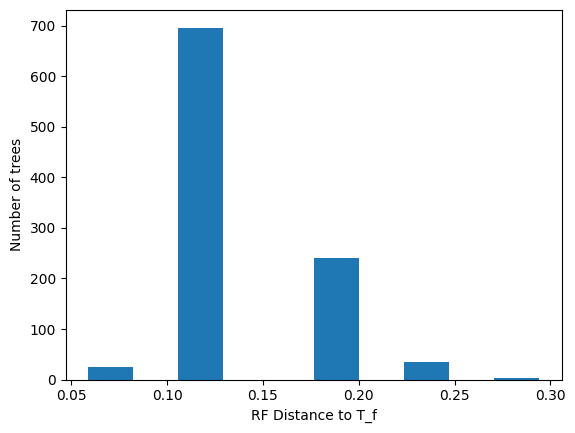

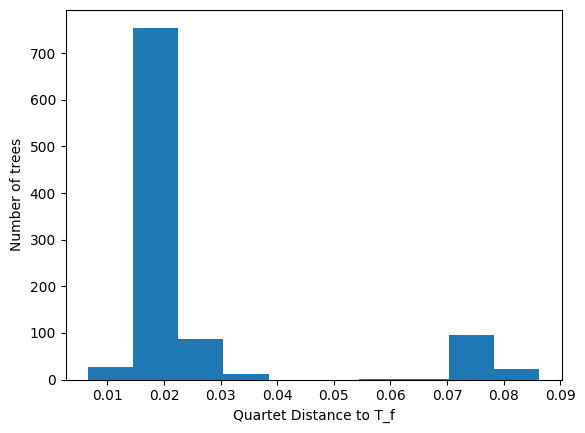

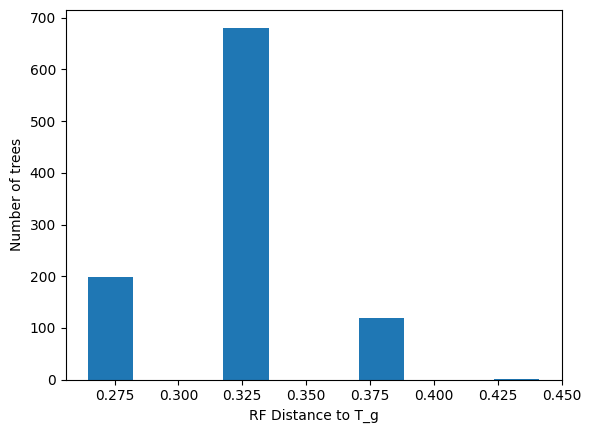

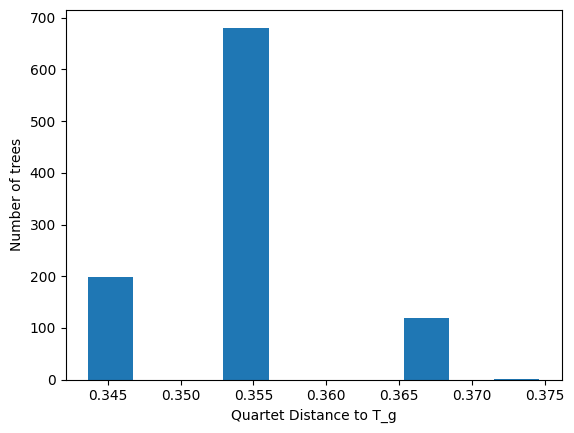

In [5]:
def fixed_analysis(name, metric):
    if metric == "RF":
        f_name = "temp/" + name + "_dist.matrix"
    elif metric == "Quartet":
        f_name = "temp/" + name + "_quartet_dist.matrix"
    else:
        print(metric + " - this metric is not supported")
    d = [float(val) for val in open(f_name, "r").read().split("\n")[:-1]]
    if metric == "RF":
        d = [val/34 for val in d]
    plt.xlabel(metric+" Distance to " + name_dict[name])
    plt.ylabel("Number of trees")
    plt.hist(d)
    plt.show()

fixed_analysis("full", "RF")
fixed_analysis("full", "Quartet")
fixed_analysis("glottolog", "RF")
fixed_analysis("glottolog", "Quartet")

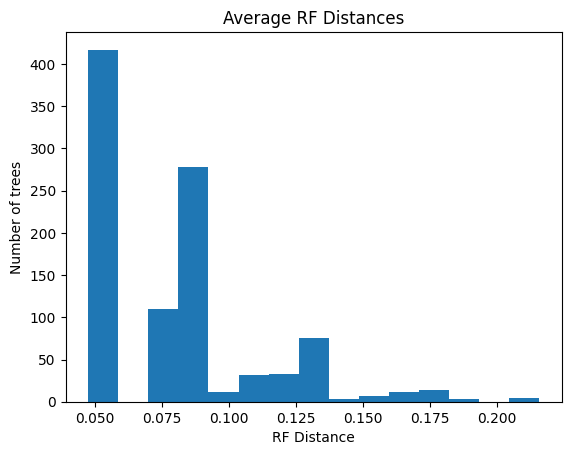

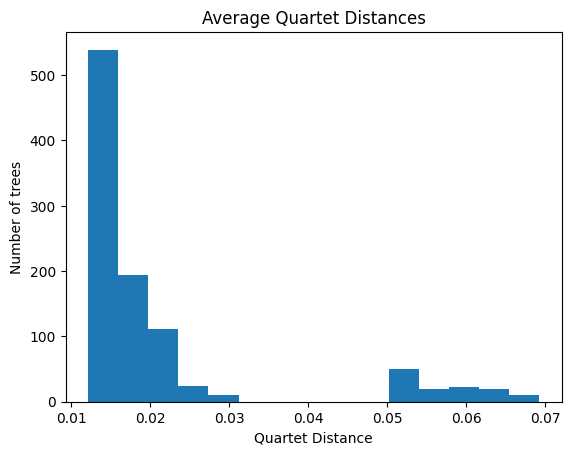

In [6]:
def matrix_analysis(metric):
    dm = read_dm(metric)
    if metric == "RF":
        dm = to_relative(dm)
    upper_triangle = [dm[i][j] for i in range(1000) for j in range(i+1, 1000)]
    avgs = [sum(dm[i]) / 999 for i in range(1000)]
    avg = sum(upper_triangle) / len(upper_triangle)
    #print(avg)
    plt.title("Average " + metric + " Distances")
    plt.xlabel(metric + " Distance")
    plt.ylabel("Number of trees")
    plt.hist(avgs, bins=15)
    plt.show()

    #plt.title("Distribution of pairwise " + metric + " Distances")
    #plt.xlabel(metric + " Distance")
    #plt.ylabel("Number of tree pairs")
    #plt.hist(upper_triangle, bins=10)
    #plt.show()
matrix_analysis("RF")
matrix_analysis("Quartet")

full, RF, 0.7141601184734127
full, Quartet, 0.9736040942665151
glottolog, RF, 0.04333514179243622
glottolog, Quartet, 0.11814363701810669


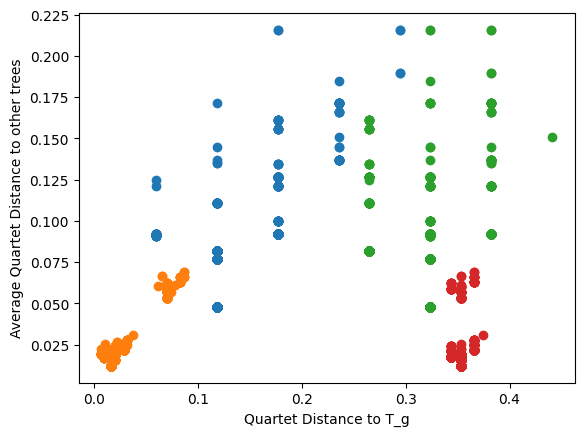

In [8]:
def fixed_avg_correlation(name, metric):
    if metric == "RF":
        f_name = "temp/" + name + "_dist.matrix"
    elif metric == "Quartet":
        f_name = "temp/" + name + "_quartet_dist.matrix"
    else:
        print(metric + " - this metric is not supported")
    d = [float(val) for val in open(f_name, "r").read().split("\n")[:-1]]
    if metric == "RF":
        d = [val/34 for val in d]
        
        
    dm = read_dm(metric)
    if metric == "RF":
        dm = to_relative(dm)
    upper_triangle = [dm[i][j] for i in range(1000) for j in range(i+1, 1000)]
    avgs = [sum(dm[i]) / 999 for i in range(1000)]
    print(name + ", " + metric + ", " + str(np.corrcoef(d, avgs)[0, 1]))
    plt.xlabel(metric+" Distance to " + name_dict[name])
    plt.ylabel("Average " + metric + " Distance to other trees")
    plt.scatter(d, avgs)
    #plt.show()
    
    
fixed_avg_correlation("full", "RF")
fixed_avg_correlation("full", "Quartet")
fixed_avg_correlation("glottolog", "RF")
fixed_avg_correlation("glottolog", "Quartet")



In [11]:
T_g_name = os.path.join("ref_trees", "glottolog.tree")
T_f_name = os.path.join("ref_trees", "full.tree")
T_g = Tree(T_g_name)
T_f = Tree(T_f_name)


qdist = quartet_distance(T_g_name, T_f_name)
rf = rf_distance(T_g, T_f)/34

print("RF Distance: " + str(rf))
print("Quartet Distance: " + str(qdist))

RF Distance: 0.3235294117647059
Quartet Distance: 0.352941
